<a href="https://colab.research.google.com/github/punyamsingh/IRIS/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Upgrade torch and sentence-transformers to compatible versions
!pip install --upgrade torch sentence-transformers


  Using cached sentence_transformers-3.3.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Load CSV data
csv_file = '/content/multilabel_classification(2).csv'
csv_data = pd.read_csv(csv_file)

# Load JSON data
json_file = '/content/image_tags.json'
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)

# Filter CSV data to only include images present in JSON
csv_data = csv_data[csv_data['Image_Name'].isin(image_tags_mapping.keys())]
# print(csv_data)


/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [10]:
# Step 1: Strip whitespace from column names to remove any hidden spaces or newline characters
csv_data.columns = csv_data.columns.str.strip()

# Print the column names again to confirm the exact format
print("Column names:", csv_data.columns)

# Updated function to generate relevance data
def generate_relevance_data(csv_data):
    relevance_data = {}

    # Try to access the column by its cleaned name
    column_name = 'Classes(motorcycle, truck, boat, bus, cycle, person, desert, mountains, sea, sunset, trees, sitar, ektara, flutes, tabla, harmonium)'

    for _, row in csv_data.iterrows():
        image_name = row['Image_Name']
        # print(image_name)  # Debug: Print image name

        try:
            # Access the column using the cleaned column name
            classes = str(row[column_name]).split()  # Get the true tags for the image
            relevance_data[image_name] = classes
        except KeyError:
            print(f"Column '{column_name}' not found. Available columns are: {csv_data.columns}")
            break  # Break out of the loop if the column name is incorrect

    return relevance_data

# Generate the relevance data
relevance_data = generate_relevance_data(csv_data)

# Print the output to verify
print(relevance_data)
print(len(relevance_data))


Column names: Index(['Image_Name',
       'Classes(motorcycle, truck, boat, bus, cycle, person, desert, mountains, sea, sunset, trees, sitar, ektara, flutes, tabla, harmonium)',
       'motorcycle', 'truck', 'boat', 'bus', 'cycle', 'person', 'desert',
       'mountains', 'sea', 'sunset', 'trees', 'sitar', 'ektara', 'flutes',
       'tabla', 'harmonium'],
      dtype='object')
{'image1.jpg': ['bus', 'person'], 'image2.jpg': ['sitar'], 'image3.jpg': ['flutes'], 'image4.jpg': ['bus', 'trees'], 'image5.jpg': ['bus'], 'image6.jpg': ['sitar', 'ektara', 'tabla'], 'image7.jpg': ['sitar', 'tabla'], 'image8.jpg': ['sitar', 'ektara', 'tabla'], 'image9.jpg': ['person', 'tabla'], 'image10.jpg': ['sitar'], 'image11.jpg': ['tabla', 'harmonium'], 'image12.jpg': ['person', 'harmonium'], 'image13.jpg': ['tabla'], 'image14.jpg': ['tabla'], 'image15.jpg': ['sitar', 'ektara', 'flutes', 'tabla', 'harmonium'], 'image16.jpg': ['bus'], 'image17.jpg': ['person', 'flutes'], 'image18.jpg': ['person', 'sitar', 'ta

In [3]:
# Initialize models
tfidf_vectorizer = TfidfVectorizer()
st_model = SentenceTransformer('all-mpnet-base-v2')

def get_literal_similarity(query, image_tags):
    all_tags = ' '.join(image_tags)
    X = tfidf_vectorizer.fit_transform([query, all_tags])
    return 1 - cosine(X[0].toarray().flatten(), X[1].toarray().flatten())

def get_semantic_similarity(query, image_tags):
    query_embed = st_model.encode(query)
    tags_embed = st_model.encode(image_tags)
    tags_mean_embed = np.mean(tags_embed, axis=0)
    return 1 - cosine(query_embed, tags_mean_embed)

def rank_images(query, threshold=0.2):
    similarity_scores = []
    for filename, tags in image_tags_mapping.items():
        literal_sim = get_literal_similarity(query, tags)
        semantic_sim = get_semantic_similarity(query, tags)
        total_score = literal_sim + semantic_sim
        if total_score >= threshold:
            similarity_scores.append((filename, total_score))
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    return similarity_scores


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [34]:
import os
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from PIL import Image
from IPython.display import display

# Load the image tags from the JSON file
with open('image_tags.json', 'r') as f:
    image_tags_mapping = json.load(f)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Initialize the Sentence Transformer model for semantic similarity
st_model = SentenceTransformer('all-mpnet-base-v2')

def get_literal_similarity(query, image_tags):
    """Calculate literal similarity between the query and image tags using TF-IDF."""
    all_tags = ' '.join(image_tags)
    X = tfidf_vectorizer.fit_transform([query, all_tags])
    literal_sim = 1 - cosine(X[0].toarray().flatten(), X[1].toarray().flatten())
    return literal_sim

def get_semantic_similarity(query, image_tags):
    """Calculate semantic similarity between the query and image tags using Sentence Transformer."""
    query_embed = st_model.encode(query)
    tags_embed = st_model.encode(image_tags)
    tags_mean_embed = np.mean(tags_embed, axis=0)
    semantic_sim = 1 - cosine(query_embed, tags_mean_embed)
    return semantic_sim

def rank_images(query, display_size=(200, 200), threshold=0.2):
    """Rank images based on the sum of literal and semantic similarity scores to the query and display resized images in Jupyter Notebook."""
    similarity_scores = []
    for filename, tags in image_tags_mapping.items():
        literal_sim = get_literal_similarity(query, tags)
        semantic_sim = get_semantic_similarity(query, tags)
        total_score = literal_sim + semantic_sim
        if total_score >= threshold:
            similarity_scores.append((filename, literal_sim, semantic_sim, total_score))

    # Sort images based on the combined score
    similarity_scores.sort(key=lambda x: x[3], reverse=True)

    return similarity_scores

def classify_images_based_on_similarity(similarity_scores, threshold=0.5):
    """Classify images as relevant or non-relevant based on similarity threshold."""
    relevant_images = [(img, score) for img, literal, semantic, score in similarity_scores if score >= threshold]
    non_relevant_images = [(img, score) for img, literal, semantic, score in similarity_scores if score < threshold]

    return relevant_images, non_relevant_images

def calculate_precision_recall(relevant_images, total_retrieved):
    """Calculate precision and recall."""
    retrieved_relevant = len(relevant_images)
    precision = retrieved_relevant / total_retrieved if total_retrieved else 0
    recall = retrieved_relevant / len(image_tags_mapping)  # Total number of images in the dataset
    return precision, recall

def calculate_map(relevant_images_list):
    """Calculate Mean Average Precision (MAP)."""
    ap_list = []
    for relevant_images in relevant_images_list:
        ap = 0
        for i, (image, score) in enumerate(relevant_images):
            if score >= 0.5:  # Assuming relevance of an image is determined by score >= 0.5
                ap += (i + 1) / (i + 1)  # Precision at the rank
        ap_list.append(ap / len(relevant_images))  # Average precision for this query
    return np.mean(ap_list)

def calculate_dcg(similarity_scores):
    """Calculate Discounted Cumulative Gain (DCG)."""
    dcg = 0
    for i, (image, score, _) in enumerate(similarity_scores):
        dcg += (2**score - 1) / np.log2(i + 2)
    return dcg

def calculate_ndcg(dcg, ideal_dcg):
    """Calculate Normalized Discounted Cumulative Gain (NDCG)."""
    return dcg / ideal_dcg

# Example usage
query = "Man playing flute"
similarity_scores = rank_images(query, threshold=0.4)

# Classify images based on similarity
relevant_images, non_relevant_images = classify_images_based_on_similarity(similarity_scores, threshold=0.5)

# Print relevant and non-relevant images
print("\nRelevant Images:")
for image, score in relevant_images:
    print(f"Image: {image}, Score: {score}")

print("\nNon-Relevant Images:")
for image, score in non_relevant_images:
    print(f"Image: {image}, Score: {score}")

# Calculate precision and recall
precision, recall = calculate_precision_recall(relevant_images, len(similarity_scores))
print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}")

# Calculate MAP
map_score = calculate_map([relevant_images])  # For multiple queries, add them to a list
print(f"\nMean Average Precision (MAP): {map_score:.4f}")

# Calculate DCG and NDCG
dcg_score = calculate_dcg(similarity_scores)
ideal_dcg_score = calculate_dcg(sorted(similarity_scores, key=lambda x: x[3], reverse=True))  # Ideal DCG for sorted by relevance
ndcg_score = calculate_ndcg(dcg_score, ideal_dcg_score)
print(f"\nDCG: {dcg_score:.4f}, NDCG: {ndcg_score:.4f}")

# Display the ranked images (just names) from earlier corpus and model
print("\nRanked Images (From Model):")
for image, _, _, _ in similarity_scores:
    print(image)




Relevant Images:
Image: image17.jpg, Score: 0.6548326360860589

Non-Relevant Images:
Image: image9.jpg, Score: 0.4553575176483037
Image: image21.jpg, Score: 0.4434797769128873

Precision: 0.3333, Recall: 0.0076

Mean Average Precision (MAP): 1.0000


ValueError: too many values to unpack (expected 3)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_dcg(relevances, k):
    return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances[:k]))

def evaluate_model(query, relevance_data, top_k=10):
    # Model's ranked list
    ranked_images = rank_images(query, 0.4)
    ranked_image_names = [img for img, _ in ranked_images[:top_k]]

    # Create binary relevance scores for model's ranked list
    relevance_scores = []
    for img in ranked_image_names:
        relevance_scores.append(int(any(tag in query for tag in relevance_data[img])))

    # Ideal ranked list based on relevance data
    ideal_ranking = sorted(
        relevance_data.keys(),
        key=lambda img: int(any(tag in query for tag in relevance_data[img])),
        reverse=True
    )
    ideal_ranking = ideal_ranking[:top_k]

    # Calculate Precision, Recall, F1
    precision = sum(relevance_scores) / top_k
    recall = sum(relevance_scores) / len(relevance_data)  # All relevant images for this query
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate DCG and NDCG
    dcg = calculate_dcg(relevance_scores, top_k)
    idcg = calculate_dcg(sorted(relevance_scores, reverse=True), top_k)
    ndcg = dcg / idcg if idcg > 0 else 0

    # Print results
    print(f"Query: {query}")
    print(f"Precision@{top_k}: {precision:.4f}, Recall@{top_k}: {recall:.4f}, F1@{top_k}: {f1:.4f}")
    print(f"DCG@{top_k}: {dcg:.4f}, NDCG@{top_k}: {ndcg:.4f}")

    # Print model's ranked list and ideal ranked list
    print("\nModel's Ranked List:")
    for i, img in enumerate(ranked_image_names, 1):
        print(f"{i}. {img} - Relevance: {relevance_scores[i-1]}")

    print("\nIdeal Ranked List:")
    for i, img in enumerate(ideal_ranking, 1):
        ideal_relevance = int(any(tag in query for tag in relevance_data[img]))
        print(f"{i}. {img} - Relevance: {ideal_relevance}")

    return precision, recall, f1, ndcg

# Example query evaluation
query = "Man playing flute"
evaluate_model(query, relevance_data, top_k=10)


Query: Man playing flute
Precision@10: 0.0000, Recall@10: 0.0000, F1@10: 0.0000
DCG@10: 0.0000, NDCG@10: 0.0000

Model's Ranked List:
1. image17.jpg - Relevance: 0
2. image9.jpg - Relevance: 0
3. image21.jpg - Relevance: 0

Ideal Ranked List:
1. image1.jpg - Relevance: 0
2. image2.jpg - Relevance: 0
3. image3.jpg - Relevance: 0
4. image4.jpg - Relevance: 0
5. image5.jpg - Relevance: 0
6. image6.jpg - Relevance: 0
7. image7.jpg - Relevance: 0
8. image8.jpg - Relevance: 0
9. image9.jpg - Relevance: 0
10. image10.jpg - Relevance: 0


(0.0, 0.0, 0, 0)

METRICS PLOT

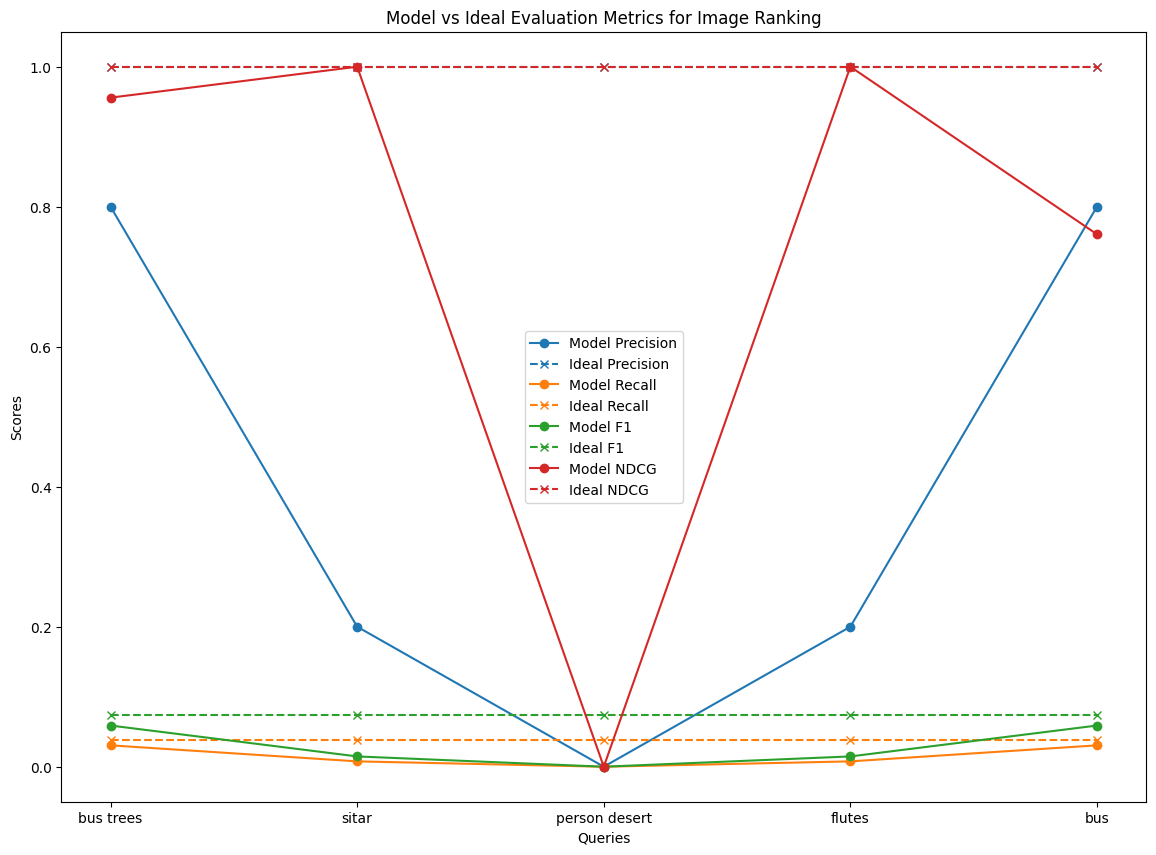

In [ ]:
# print(image_tags_mapping.items())

import matplotlib.pyplot as plt
import numpy as np

# Calculate DCG function remains the same
def calculate_dcg(relevances, k):
    return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances[:k]))

# Evaluate model function modified to return relevance scores as well
def evaluate_model(query, relevance_data, top_k=10):
    # Model's ranked list
    ranked_images = rank_images(query, 0.4)
    ranked_image_names = [img for img, _ in ranked_images[:top_k]]

    # Create binary relevance scores for model's ranked list
    model_relevance_scores = []
    for img in ranked_image_names:
        model_relevance_scores.append(int(any(tag in query for tag in relevance_data[img])))

    # Ideal ranked list based on relevance data
    ideal_ranking = sorted(
        relevance_data.keys(),
        key=lambda img: int(any(tag in query for tag in relevance_data[img])),
        reverse=True
    )
    ideal_ranking = ideal_ranking[:top_k]

    # Binary relevance scores for ideal ranking
    ideal_relevance_scores = [
        int(any(tag in query for tag in relevance_data[img])) for img in ideal_ranking
    ]

    # Calculate metrics for model ranking
    precision_model = sum(model_relevance_scores) / top_k
    recall_model = sum(model_relevance_scores) / len(relevance_data)
    f1_model = 2 * (precision_model * recall_model) / (precision_model + recall_model) if (precision_model + recall_model) > 0 else 0
    dcg_model = calculate_dcg(model_relevance_scores, top_k)
    idcg_model = calculate_dcg(sorted(model_relevance_scores, reverse=True), top_k)
    ndcg_model = dcg_model / idcg_model if idcg_model > 0 else 0

    # Calculate metrics for ideal ranking
    precision_ideal = sum(ideal_relevance_scores) / top_k
    recall_ideal = sum(ideal_relevance_scores) / len(relevance_data)
    f1_ideal = 2 * (precision_ideal * recall_ideal) / (precision_ideal + recall_ideal) if (precision_ideal + recall_ideal) > 0 else 0
    dcg_ideal = calculate_dcg(ideal_relevance_scores, top_k)
    idcg_ideal = calculate_dcg(sorted(ideal_relevance_scores, reverse=True), top_k)
    ndcg_ideal = dcg_ideal / idcg_ideal if idcg_ideal > 0 else 0

    return {
        'model': (precision_model, recall_model, f1_model, ndcg_model),
        'ideal': (precision_ideal, recall_ideal, f1_ideal, ndcg_ideal)
    }

# Evaluate metrics for each query and store results for both model and ideal rankings
queries = ["bus trees", "sitar", "person desert", "flutes", "bus"]
metrics_model = {'Precision': [], 'Recall': [], 'F1': [], 'NDCG': []}
metrics_ideal = {'Precision': [], 'Recall': [], 'F1': [], 'NDCG': []}

for query in queries:
    results = evaluate_model(query, relevance_data, top_k=5)

    # Append model metrics
    metrics_model['Precision'].append(results['model'][0])
    metrics_model['Recall'].append(results['model'][1])
    metrics_model['F1'].append(results['model'][2])
    metrics_model['NDCG'].append(results['model'][3])

    # Append ideal metrics
    metrics_ideal['Precision'].append(results['ideal'][0])
    metrics_ideal['Recall'].append(results['ideal'][1])
    metrics_ideal['F1'].append(results['ideal'][2])
    metrics_ideal['NDCG'].append(results['ideal'][3])

# Plotting the metrics
plt.figure(figsize=(14, 10))
for metric in metrics_model.keys():
    plt.plot(queries, metrics_model[metric], label=f'Model {metric}', marker='o', linestyle='-', color=f'C{list(metrics_model.keys()).index(metric)}')
    plt.plot(queries, metrics_ideal[metric], label=f'Ideal {metric}', marker='x', linestyle='--', color=f'C{list(metrics_model.keys()).index(metric)}')

plt.xlabel("Queries")
plt.ylabel("Scores")
plt.title("Model vs Ideal Evaluation Metrics for Image Ranking")
plt.legend()
plt.show()


METRICS FOR MULTIPLE QUERIES SANS PLOT


In [ ]:
# Calculate DCG function remains the same
def calculate_dcg(relevances, k):
    return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances[:k]))

# Evaluate model function modified to return relevance scores and ranked lists
def evaluate_model(query, relevance_data, top_k=10):
    # Model's ranked list
    ranked_images = rank_images(query, 0.4)
    ranked_image_names = [img for img, _ in ranked_images[:top_k]]

    # Create binary relevance scores for model's ranked list
    model_relevance_scores = []
    for img in ranked_image_names:
        model_relevance_scores.append(int(any(tag in query for tag in relevance_data[img])))

    # Ideal ranked list based on relevance data
    ideal_ranking = sorted(
        relevance_data.keys(),
        key=lambda img: int(any(tag in query for tag in relevance_data[img])),
        reverse=True
    )
    ideal_ranking = ideal_ranking[:top_k]

    # Binary relevance scores for ideal ranking
    ideal_relevance_scores = [
        int(any(tag in query for tag in relevance_data[img])) for img in ideal_ranking
    ]

    return {
        'model_ranking': [(img, score) for img, score in zip(ranked_image_names, model_relevance_scores)],
        'ideal_ranking': [(img, score) for img, score in zip(ideal_ranking, ideal_relevance_scores)]
    }

# Evaluate and print the ranked lists for each query
queries = ["bus trees", "sitar", "person desert", "flutes", "bus"]
for query in queries:
    results = evaluate_model(query, relevance_data, top_k=5)

    print(f"Query: {query}")
    print("Model's Ranked List:")
    for img, relevance in results['model_ranking']:
        print(f"  {img} - Relevance: {relevance}")
    print("Ideal Ranked List:")
    for img, relevance in results['ideal_ranking']:
        print(f"  {img} - Relevance: {relevance}")
    print("\n" + "="*50 + "\n")


PRECISION VS RECALL CURVE AND INTERPOLATED CURVE

Query: Man playing flute
Precision@10: 0.0000, Recall@10: 0.0000, F1@10: 0.0000
DCG@10: 0.0000, NDCG@10: 0.0000

Model's Ranked List:
1. image17.jpg - Relevance: 0
2. image9.jpg - Relevance: 0
3. image21.jpg - Relevance: 0

Ideal Ranked List:
1. image1.jpg - Relevance: 0
2. image2.jpg - Relevance: 0
3. image3.jpg - Relevance: 0
4. image4.jpg - Relevance: 0
5. image5.jpg - Relevance: 0
6. image6.jpg - Relevance: 0
7. image7.jpg - Relevance: 0
8. image8.jpg - Relevance: 0
9. image9.jpg - Relevance: 0
10. image10.jpg - Relevance: 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


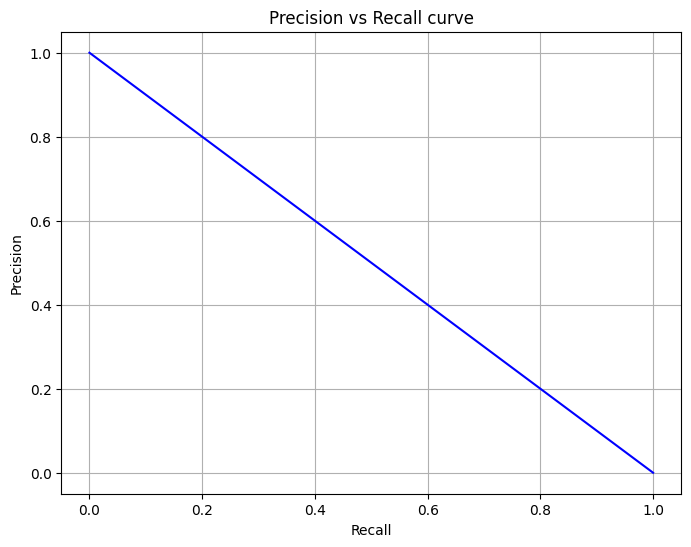

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


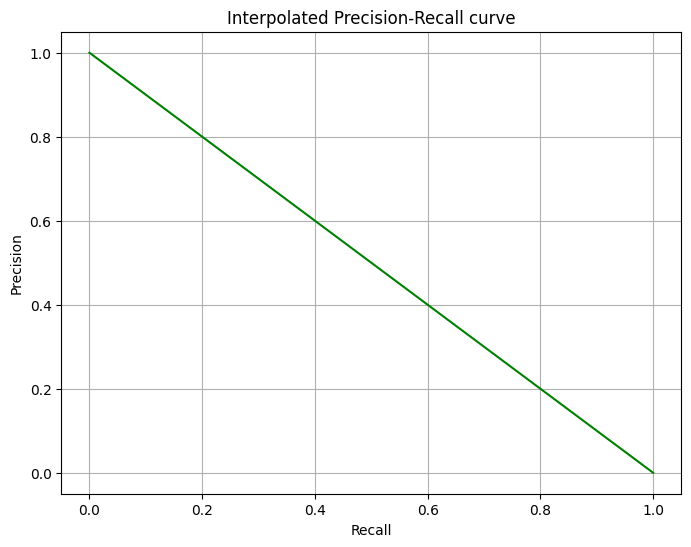

MAP: 0.0000


(0.0, 0.0, 0, 0, 0.0)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def calculate_average_precision(relevance_scores, y_true):
    # Calculate precision at each relevant point
    relevant = 0
    precision_sum = 0.0
    for i, (score, true_label) in enumerate(zip(relevance_scores, y_true)):
        if true_label == 1:  # Relevant document
            relevant += 1
            precision_at_i = sum(relevance_scores[:i+1]) / (i + 1)  # Precision at rank i+1
            precision_sum += precision_at_i
    return precision_sum / relevant if relevant > 0 else 0

def calculate_map(relevance_scores_list, y_true_list):
    ap_scores = []
    for relevance_scores, y_true in zip(relevance_scores_list, y_true_list):
        ap = calculate_average_precision(relevance_scores, y_true)
        ap_scores.append(ap)
    return np.mean(ap_scores)  # Mean of Average Precision for all queries

def plot_precision_recall_curve(relevance_scores, y_true):
    precision, recall, _ = precision_recall_curve(y_true, relevance_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall curve')
    plt.grid(True)
    plt.show()

def plot_interpolated_precision_recall_curve(relevance_scores, y_true):
    precision, recall, _ = precision_recall_curve(y_true, relevance_scores)
    interpolated_precision = np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1])
    interpolated_recall = np.linspace(0, 1, 100)

    plt.figure(figsize=(8, 6))
    plt.plot(interpolated_recall, interpolated_precision, label='Interpolated Precision-Recall curve', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Interpolated Precision-Recall curve')
    plt.grid(True)
    plt.show()

def evaluate_model_with_plots(query, relevance_data, top_k=10):
    # Model's ranked list
    ranked_images = rank_images(query, 0.4)
    ranked_image_names = [img for img, _ in ranked_images[:top_k]]

    # Create binary relevance scores for model's ranked list
    relevance_scores = []
    y_true = []
    for img in ranked_image_names:
        relevance = int(any(tag in query for tag in relevance_data[img]))
        relevance_scores.append(relevance)
        y_true.append(relevance)  # True binary relevance for each image

    # Calculate Precision, Recall, F1
    precision = sum(relevance_scores) / top_k
    recall = sum(relevance_scores) / len(relevance_data)  # All relevant images for this query
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate DCG and NDCG
    dcg = calculate_dcg(relevance_scores, top_k)
    idcg = calculate_dcg(sorted(relevance_scores, reverse=True), top_k)
    ndcg = dcg / idcg if idcg > 0 else 0

    # Print results
    print(f"Query: {query}")
    print(f"Precision@{top_k}: {precision:.4f}, Recall@{top_k}: {recall:.4f}, F1@{top_k}: {f1:.4f}")
    print(f"DCG@{top_k}: {dcg:.4f}, NDCG@{top_k}: {ndcg:.4f}")

    # Print model's ranked list and ideal ranked list
    print("\nModel's Ranked List:")
    for i, img in enumerate(ranked_image_names, 1):
        print(f"{i}. {img} - Relevance: {relevance_scores[i-1]}")

    print("\nIdeal Ranked List:")
    ideal_ranking = sorted(
        relevance_data.keys(),
        key=lambda img: int(any(tag in query for tag in relevance_data[img])),
        reverse=True
    )[:top_k]

    for i, img in enumerate(ideal_ranking, 1):
        ideal_relevance = int(any(tag in query for tag in relevance_data[img]))
        print(f"{i}. {img} - Relevance: {ideal_relevance}")

    # Plot Precision-Recall curve and interpolated curve
    plot_precision_recall_curve(relevance_scores, y_true)
    plot_interpolated_precision_recall_curve(relevance_scores, y_true)

    # Calculate and print MAP score
    map_score = calculate_map([relevance_scores], [y_true])
    print(f"MAP: {map_score:.4f}")

    return precision, recall, f1, ndcg, map_score

# Example query evaluation
query = "Man playing flute"
evaluate_model_with_plots(query, relevance_data, top_k=10)


STEP BY STEP NEW APPROACH.
LATEST
1. Calculate cosine similarity between query and tag vectors of all images
2. Define a certain threshold to classify images as relevant and non relevant for a particular query
3. Run the model and retrieve ranked set of images
4. Compute metric scores

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download NLTK resources for lemmatization and stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Load data
csv_file = '/content/multilabel_classification(2).csv'  # replace with actual path
json_file = '/content/image_tags.json'  # replace with actual path

# Step 1: Load and Filter CSV Data
csv_data = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)

# Filter CSV to only include images present in JSON data
csv_data = csv_data[csv_data['Image_Name'].isin(image_tags_mapping.keys())].reset_index(drop=True)

# Columns representing tag presence (binary vector fields)
original_tag_columns = csv_data.columns[2:]  # Assuming first two columns are 'Image_Name' and 'Classes'

# Step 2: Lemmatize CSV Columns for Consistency and Remove Stopwords
tag_columns = [lemmatizer.lemmatize(tag) for tag in original_tag_columns if tag not in stop_words]
csv_data.columns = list(csv_data.columns[:2]) + tag_columns  # Replace with processed columns

# Step 3: Formulate Query with Lemmatization and Stopword Removal
query_terms = ["person", "flutes"]  # Example terms, feel free to adjust
lemmatized_query_terms = [lemmatizer.lemmatize(term) for term in query_terms if term not in stop_words]

# Create binary vector for query
query_vector = np.array([1 if col in lemmatized_query_terms else 0 for col in tag_columns]).reshape(1, -1)

# Step 4: Compute Cosine Similarity between Query Vector and each Image Vector
image_vectors = csv_data[tag_columns].values  # Extract binary vectors for each image
similarities = cosine_similarity(query_vector, image_vectors).flatten()  # Cosine similarity with query

# Step 5: Set Threshold and Classify as Relevant or Non-Relevant
threshold = 0.3  # Define your threshold for relevance

# Create lists for relevant and non-relevant images
relevant_images = [(img, score) for img, score in zip(csv_data['Image_Name'], similarities) if score >= threshold]
non_relevant_images = [(img, score) for img, score in zip(csv_data['Image_Name'], similarities) if score < threshold]

# Print relevant images
print("Relevant Images based on Similarity (Threshold = 0.5):")
for image, score in relevant_images:
    print(f"Image: {image}, Similarity Score: {score}")

# Print non-relevant images
print("\nNon-Relevant Images based on Similarity (Below Threshold):")
for image, score in non_relevant_images:
    print(f"Image: {image}, Similarity Score: {score}")


In [ ]:
import os
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from PIL import Image
from IPython.display import display

# Load the image tags from the JSON file
with open('image_tags.json', 'r') as f:
    image_tags_mapping = json.load(f)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Initialize the Sentence Transformer model for semantic similarity
st_model = SentenceTransformer('all-mpnet-base-v2')

def get_literal_similarity(query, image_tags):
    """Calculate literal similarity between the query and image tags using TF-IDF."""
    all_tags = ' '.join(image_tags)
    X = tfidf_vectorizer.fit_transform([query, all_tags])
    literal_sim = 1 - cosine(X[0].toarray().flatten(), X[1].toarray().flatten())
    return literal_sim

def get_semantic_similarity(query, image_tags):
    """Calculate semantic similarity between the query and image tags using Sentence Transformer."""
    query_embed = st_model.encode(query)
    tags_embed = st_model.encode(image_tags)
    tags_mean_embed = np.mean(tags_embed, axis=0)
    semantic_sim = 1 - cosine(query_embed, tags_mean_embed)
    return semantic_sim

def rank_images(query, display_size=(200, 200), threshold=0.2):
    """Rank images based on the sum of literal and semantic similarity scores to the query and display resized images in Jupyter Notebook."""
    similarity_scores = []
    for filename, tags in image_tags_mapping.items():
        literal_sim = get_literal_similarity(query, tags)
        semantic_sim = get_semantic_similarity(query, tags)
        total_score = literal_sim + semantic_sim
        if total_score >= threshold:
            similarity_scores.append((filename, literal_sim, semantic_sim, total_score))

    # Sort images based on the combined score
    similarity_scores.sort(key=lambda x: x[3], reverse=True)

    return similarity_scores

def classify_images_based_on_similarity(similarity_scores, threshold=0.5):
    """Classify images as relevant or non-relevant based on similarity threshold."""
    relevant_images = [(img, score) for img, literal, semantic, score in similarity_scores if score >= threshold]
    non_relevant_images = [(img, score) for img, literal, semantic, score in similarity_scores if score < threshold]

    return relevant_images, non_relevant_images

def calculate_precision_recall(relevant_images, total_retrieved):
    """Calculate precision and recall."""
    retrieved_relevant = len(relevant_images)
    precision = retrieved_relevant / total_retrieved if total_retrieved else 0
    recall = retrieved_relevant / len(image_tags_mapping)  # Total number of images in the dataset
    return precision, recall

def calculate_map(relevant_images_list):
    """Calculate Mean Average Precision (MAP)."""
    ap_list = []
    for relevant_images in relevant_images_list:
        ap = 0
        for i, (image, score) in enumerate(relevant_images):
            if score >= 0.5:  # Assuming relevance of an image is determined by score >= 0.5
                ap += (i + 1) / (i + 1)  # Precision at the rank
        ap_list.append(ap / len(relevant_images))  # Average precision for this query
    return np.mean(ap_list)

def calculate_dcg(similarity_scores):
    """Calculate Discounted Cumulative Gain (DCG)."""
    dcg = 0
    for i, (image, literal_score, semantic_score, total_score) in enumerate(similarity_scores):
        dcg += (2**total_score - 1) / np.log2(i + 2)
    return dcg


def calculate_ndcg(dcg, ideal_dcg):
    """Calculate Normalized Discounted Cumulative Gain (NDCG)."""
    return dcg / ideal_dcg

# Example usage
query = "Bus"
similarity_scores = rank_images(query, threshold=0.4)

# Classify images based on similarity
relevant_images, non_relevant_images = classify_images_based_on_similarity(similarity_scores, threshold=0.5)

# Print relevant and non-relevant images
print("\nRelevant Images:")
for image, score in relevant_images:
    print(f"Image: {image}, Score: {score}")

print("\nNon-Relevant Images:")
for image, score in non_relevant_images:
    print(f"Image: {image}, Score: {score}")

# Calculate precision and recall
precision, recall = calculate_precision_recall(relevant_images, len(similarity_scores))
print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}")

# Calculate MAP
map_score = calculate_map([relevant_images])  # For multiple queries, add them to a list
print(f"\nMean Average Precision (MAP): {map_score:.4f}")

# Calculate DCG and NDCG
dcg_score = calculate_dcg(similarity_scores)
ideal_dcg_score = calculate_dcg(sorted(similarity_scores, key=lambda x: x[3], reverse=True))  # Ideal DCG for sorted by relevance
ndcg_score = calculate_ndcg(dcg_score, ideal_dcg_score)
print(f"\nDCG: {dcg_score:.4f}, NDCG: {ndcg_score:.4f}")

# Display the ranked images (just names) from earlier corpus and model
print("\nRanked Images (From Model):")
for image, _, _, _ in similarity_scores:
    print(image)




Relevant Images:
Image: image3188.jpg, Score: 0.8911869401565738
Image: image1.jpg, Score: 0.8592914962096011
Image: image5.jpg, Score: 0.8332425955529378
Image: image16.jpg, Score: 0.8162060803659114
Image: image27.jpg, Score: 0.8116758136367417
Image: image4.jpg, Score: 0.6082718107154046
Image: image3167.jpg, Score: 0.5574493357124907
Image: image3173.jpg, Score: 0.5476790970338402
Image: image3203.jpg, Score: 0.5430424532423151
Image: image3162.jpg, Score: 0.5369020284787615
Image: image3184.jpg, Score: 0.5367988459238716
Image: image3197.jpg, Score: 0.5365890569682145
Image: image3181.jpg, Score: 0.5365245064812928
Image: image3185.jpg, Score: 0.5327159062991331
Image: image3195.jpg, Score: 0.5315353745463145
Image: image3200.jpg, Score: 0.5314555505480288
Image: image4658.jpg, Score: 0.5311784781936121
Image: image3180.jpg, Score: 0.5255990760451891
Image: image3204.jpg, Score: 0.5200702200544968
Image: image3186.jpg, Score: 0.5141837239055804
Image: image3207.jpg, Score: 0.5139

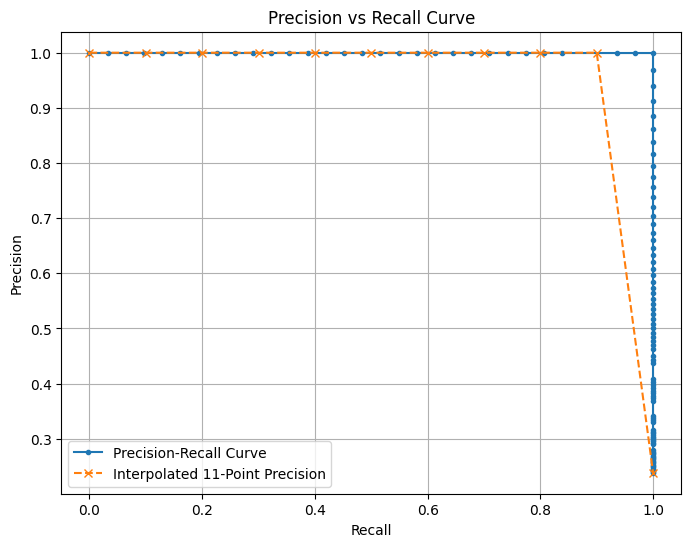

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Function to calculate precision, recall, and plot the curves
def plot_precision_recall_curve(query, similarity_scores, threshold=0.5):
    # Extract the relevance labels and predicted scores
    y_true = [1 if score >= threshold else 0 for _, _, _, score in similarity_scores]  # Relevance labels
    y_scores = [score for _, _, _, score in similarity_scores]  # Prediction scores

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Interpolate precision at 11 recall levels
    recall_levels = np.linspace(0, 1, 11)
    precision_interpolated = np.interp(recall_levels, recall[::-1], precision[::-1])

    # Plot Precision vs Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')

    # Plot interpolated 11-point Precision-Recall curve
    plt.plot(recall_levels, precision_interpolated, marker='x', linestyle='--', label='Interpolated 11-Point Precision')

    # Add labels and legend
    plt.title('Precision vs Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')

    # Show plot
    plt.grid(True)
    plt.show()

# Example usage
query = "Bus"
similarity_scores = rank_images(query, threshold=0.4)

# Classify images based on similarity
relevant_images, non_relevant_images = classify_images_based_on_similarity(similarity_scores, threshold=0.5)

# Print relevant and non-relevant images
print("\nRelevant Images:")
for image, score in relevant_images:
    print(f"Image: {image}, Score: {score}")

print("\nNon-Relevant Images:")
for image, score in non_relevant_images:
    print(f"Image: {image}, Score: {score}")

# Plot Precision-Recall curve
plot_precision_recall_curve(query, similarity_scores, threshold=0.5)


JACCARD

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import json
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load data
csv_file = '/content/multilabel_classification(2).csv'  # replace with actual path
json_file = '/content/image_tags.json'  # replace with actual path

# Step 1: Load and Filter CSV Data
csv_data = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)

# Filter CSV to only include images present in JSON data
csv_data = csv_data[csv_data['Image_Name'].isin(image_tags_mapping.keys())].reset_index(drop=True)

# Step 2: Lemmatize CSV Columns for Consistency
# Columns representing tag presence (binary vector fields)
original_tag_columns = csv_data.columns[2:]  # Assuming first two columns are 'Image_Name' and 'Classes'

# Lemmatize each column name
tag_columns = [lemmatizer.lemmatize(tag) for tag in original_tag_columns]
csv_data.columns = list(csv_data.columns[:2]) + tag_columns

# Step 3: Formulate Query with Lemmatization
query_terms = ["sitars"]  # Example terms; feel free to adjust

# Lemmatize query terms
lemmatized_query_terms = [lemmatizer.lemmatize(term) for term in query_terms]

# Create binary vector for query
query_vector = np.array([1 if col in lemmatized_query_terms else 0 for col in tag_columns]).reshape(1, -1)

# Step 4: Compute Jaccard Similarity between Query Vector and each Image Vector
image_vectors = csv_data[tag_columns].values  # Extract binary vectors for each image
jaccard_similarities = [jaccard_score(query_vector.flatten(), img_vec, average='binary') for img_vec in image_vectors]

# Step 5: Rank Images Based on Jaccard Similarity Scores
ranked_images = sorted(
    zip(csv_data['Image_Name'], jaccard_similarities),
    key=lambda x: x[1],
    reverse=True
)

# Print top-ranked images
print("Ranked Images based on Jaccard Similarity (Highest to Lowest):")
for image, score in ranked_images:
    print(f"Image: {image}, Similarity Score: {score}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Ranked Images based on Jaccard Similarity (Highest to Lowest):
Image: image2.jpg, Similarity Score: 1.0
Image: image10.jpg, Similarity Score: 1.0
Image: image22.jpg, Similarity Score: 1.0
Image: image23.jpg, Similarity Score: 1.0
Image: image24.jpg, Similarity Score: 1.0
Image: image32.jpg, Similarity Score: 1.0
Image: image7.jpg, Similarity Score: 0.5
Image: image34.jpg, Similarity Score: 0.5
Image: image6.jpg, Similarity Score: 0.3333333333333333
Image: image8.jpg, Similarity Score: 0.3333333333333333
Image: image19.jpg, Similarity Score: 0.3333333333333333
Image: image29.jpg, Similarity Score: 0.3333333333333333
Image: image18.jpg, Similarity Score: 0.25
Image: image33.jpg, Similarity Score: 0.25
Image: image15.jpg, Similarity Score: 0.2
Image: image35.jpg, Similarity Score: 0.2
Image: image1.jpg, Similarity Score: 0.0
Image: image3.jpg, Similarity Score: 0.0
Image: image4.jpg, Similarity Score: 0.0
Image: image5.jpg, Similarity Score: 0.0
Image: image9.jpg, Similarity Score: 0.0
Im